In [27]:
import pandas as pd
import os
import time
from datetime import timedelta, datetime
from dateutil import parser
import math
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as numpy
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, LeakyReLU, LSTM
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import os
import tensorflow as tf
from sklearn.metrics import mean_squared_error


In [28]:
df = pd.read_csv('data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv')
df.head()

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume,Close_time,Quote_av,Trades,Tb_base_av,Tb_quote_av,Ignore
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448,1606780379999,1.195970e+06,986,41.370690,8.168287e+05,0
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054,1606780439999,2.349155e+06,1683,68.558198,1.351917e+06,0
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917,1606780499999,1.915027e+06,2217,37.528715,7.392528e+05,0
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287,1606780559999,2.221748e+06,2162,65.823884,1.294934e+06,0
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827,1606780619999,1.579052e+06,1776,34.951323,6.869545e+05,0
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503,1606780679999,1.143874e+06,1151,29.788851,5.858160e+05,0
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943,1606780739999,1.665254e+06,1482,31.676067,6.227900e+05,0
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571,1606780799999,2.693831e+06,1708,95.473753,1.879199e+06,0
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0


In [29]:
# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [30]:
# Produce training samples to predict future from past.
def sampler(P, F, A, sliding_window=True):
    number_of_samples = P + F
    
    if sliding_window:
        I = np.arange(number_of_samples) + np.arange(A.shape[0] - number_of_samples + 1).reshape(-1, 1)
    else:
        if A.shape[0] % number_of_samples == 0:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0], number_of_samples).reshape(-1, 1)
        else:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0] - number_of_samples, number_of_samples).reshape(-1, 1)
            
    B = A[I].reshape(-1, number_of_samples * A.shape[1], A.shape[2])
    number_of_features = P * A.shape[1]
    sample_matrix = B[:, :number_of_features]
    target_matrix = B[:, number_of_features:]
    
    return sample_matrix, target_matrix


data_file = 'data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv'
df = pd.read_csv(data_file)

# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)


number_of_backwards = 256
number_of_forwards = 16

test_df = df[-(number_of_backwards + number_of_forwards):]

df = df[:len(df)-(number_of_backwards + number_of_forwards)]


print(df)
test_df

                  Timestamp      Open      High       Low     Close     Volume
0       2020-06-01 00:00:00   9448.27   9451.74   9432.76   9439.58  75.478449
1       2020-06-01 00:01:00   9438.17   9446.20   9431.75   9442.04  71.846860
2       2020-06-01 00:02:00   9442.04   9446.66   9431.47   9443.08  36.138885
3       2020-06-01 00:03:00   9443.08   9450.00   9421.67   9421.86  46.749705
4       2020-06-01 00:04:00   9424.25   9435.22   9422.24   9432.64  40.447054
...                     ...       ...       ...       ...       ...        ...
262975  2020-11-30 19:25:00  19279.66  19300.00  19279.66  19295.01  63.166917
262976  2020-11-30 19:26:00  19295.01  19310.00  19279.66  19309.51  83.665927
262977  2020-11-30 19:27:00  19308.56  19310.00  19282.16  19291.61  56.956399
262978  2020-11-30 19:28:00  19291.62  19300.00  19282.16  19295.53  23.787360
262979  2020-11-30 19:29:00  19295.54  19300.10  19293.21  19299.89  35.919617

[262980 rows x 6 columns]


,Timestamp,Open,High,Low,Close,Volume
262980,2020-11-30 19:30:00,19299.89,19315.00,19200.77,19211.54,133.579779
262981,2020-11-30 19:31:00,19211.55,19231.86,19200.88,19219.18,95.678271
262982,2020-11-30 19:32:00,19219.18,19255.50,19216.35,19251.39,36.612857
262983,2020-11-30 19:33:00,19252.36,19252.36,19225.10,19231.58,35.311294
262984,2020-11-30 19:34:00,19231.58,19237.30,19218.35,19226.64,39.491231
...,...,...,...,...,...,...
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [31]:
columns = ['Close']
o_df = df
time_stamps = df['Timestamp']
df = df.loc[:,columns]
real_df = o_df.loc[:,columns]

real_df

,Close
0,9439.58
1,9442.04
2,9443.08
3,9421.86
4,9432.64
...,...
262975,19295.01
262976,19309.51
262977,19291.61
262978,19295.53


### Normalize The Data with MinMax Normalization

In [32]:
# Normalize the data with min - max normalization
scaler = MinMaxScaler()

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df

,Close
0,0.052724
1,0.052948
2,0.053043
3,0.051110
4,0.052092
...,...
262975,0.950290
262976,0.951611
262977,0.949981
262978,0.950338


### Split whole data to train and test

In [33]:

# Features are backward sample dimensions
close_data = np.array(df)[:,None,:]
print('A', close_data)

real_close_data = np.array(real_df)[:,None,:]
print('real_A', real_close_data)

time_stamps = np.array(time_stamps)[:,None,None]
print('time_stamps', time_stamps)



# Pass preprocessed close data to the sampler
X, y = sampler(number_of_backwards, number_of_forwards, close_data, sliding_window=False)
print('Data', X)
print('Labels', y)

# Pass timestamps to the sampler
backward_times, forward_times = sampler(number_of_backwards, number_of_forwards, time_stamps, sliding_window=False)

# Pass real close data to the sampler
real_X, real_Y = sampler(number_of_backwards, number_of_forwards, real_close_data, sliding_window=False)

real_close_data = np.array(real_df)
real_backwards = np.array(real_X)
real_forwards = np.array(real_Y)

A [[[0.05272414]]

 [[0.05294818]]

 [[0.05304289]]

 ...

 [[0.94998074]]

 [[0.95033775]]

 [[0.95073482]]]
real_A [[[ 9439.58]]

 [[ 9442.04]]

 [[ 9443.08]]

 ...

 [[19291.61]]

 [[19295.53]]

 [[19299.89]]]
time_stamps [[['2020-06-01 00:00:00']]

 [['2020-06-01 00:01:00']]

 [['2020-06-01 00:02:00']]

 ...

 [['2020-11-30 19:27:00']]

 [['2020-11-30 19:28:00']]

 [['2020-11-30 19:29:00']]]
Data [[[0.05272414]
  [0.05294818]
  [0.05304289]
  ...
  [0.06523578]
  [0.06549261]
  [0.06669478]]

 [[0.06359373]
  [0.063489  ]
  [0.06332507]
  ...
  [0.06256187]
  [0.0623269 ]
  [0.06249812]]

 [[0.06268938]
  [0.0625983 ]
  [0.06231689]
  ...
  [0.06332507]
  [0.06257371]
  [0.06332689]]

 ...

 [[0.87057577]
  [0.86975794]
  [0.86957033]
  ...
  [0.88325408]
  [0.88235792]
  [0.87995996]]

 [[0.88523402]
  [0.88464295]
  [0.88527955]
  ...
  [0.88023409]
  [0.87946088]
  [0.87898275]]

 [[0.88589066]
  [0.88716022]
  [0.88868023]
  ...
  [0.98774245]
  [0.98518056]
  [0.98133818]]]
La

### Linear Regression

In [34]:

output_file_name = 'LSTM-BTCUSDT-1m'

step_size = X.shape[1]
batch_size= 8
nb_features = X.shape[2]

epochs = 10

# Split training data and validation data %80 -> training
training_size = int(X.shape[0] * 0.8)

Xt = X[:training_size,:,:]
yt = y[:training_size,:,0]
Xv = X[training_size:,:,:]
yv = y[training_size:,:,0]
real_forwards_val = real_forwards[training_size:,:,:]
real_backwards_val = real_backwards[training_size:,:,:]
backward_times_val = backward_times[training_size:,:,:]
forward_times_val = forward_times[training_size:,:,:]





# LSTM

model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(step_size, nb_features), return_sequences=False))
#model.add(LSTM(units=second_units,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(LeakyReLU())
'''

model = Sequential()
model.add(LSTM(units=50, activity_regularizer=regularizers.l1(1), input_shape=(step_size, nb_features), return_sequences=False))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(LeakyReLU())
'''
model.compile(loss='mse', optimizer='adam')
model.fit(Xt, yt, batch_size=batch_size, validation_data=(Xv, yv), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True)])





real_chart_lr = np.append(real_backwards_val, real_forwards_val, axis=1)
real_chart_times_lr = np.append(backward_times_val, forward_times_val, axis=1)

print(real_chart_lr.shape, real_chart_times_lr.shape)

prediction = model.predict(Xv)
    
print(prediction.shape)

# Inverse transform for prediction
inverted_prediction = []
scaler.fit(real_close_data[:,0].reshape(-1, 1))
inverted_prediction.append(scaler.inverse_transform(prediction))

inverted_prediction = np.array(inverted_prediction)[0,:,:].reshape(-1)
print(np.array(inverted_prediction).shape)

Epoch 1/10
97/97 [==============================] - 7s 58ms/step - loss: 0.0137 - val_loss: 0.0069
Epoch 2/10
97/97 [==============================] - 5s 51ms/step - loss: 9.7734e-04 - val_loss: 0.0058
Epoch 3/10
97/97 [==============================] - 5s 50ms/step - loss: 7.1947e-04 - val_loss: 0.0058
Epoch 4/10
97/97 [==============================] - 5s 49ms/step - loss: 4.8514e-04 - val_loss: 0.0093
Epoch 5/10
97/97 [==============================] - 5s 50ms/step - loss: 3.9806e-04 - val_loss: 0.0047
Epoch 6/10
97/97 [==============================] - 5s 50ms/step - loss: 3.6125e-04 - val_loss: 0.0053
Epoch 7/10
97/97 [==============================] - 5s 49ms/step - loss: 2.7063e-04 - val_loss: 0.0017
Epoch 8/10
97/97 [==============================] - 5s 56ms/step - loss: 3.4454e-04 - val_loss: 0.0044ETA:
Epoch 9/10
97/97 [==============================] - 5s 53ms/step - loss: 2.3516e-04 - val_loss: 0.0036
Epoch 10/10
97/97 [==============================] - 5s 50ms/step - loss:

### Plot the result

Mean Squared Error =  308962.78538576205


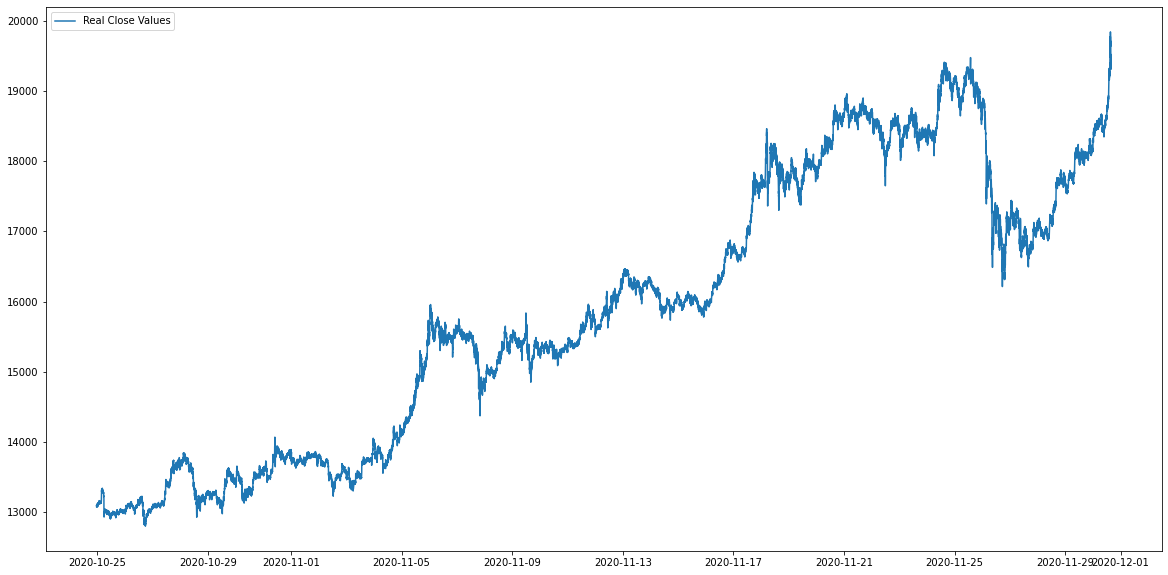

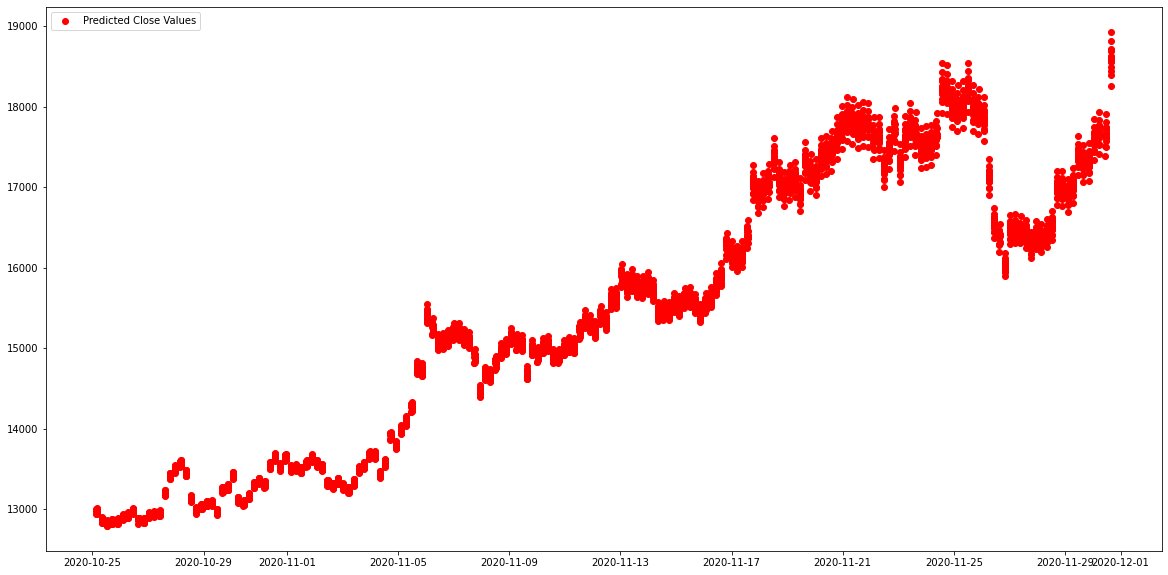

In [35]:
# Real values for chart
real_chart_lr = real_chart_lr[:,:,0].reshape(-1)

real_chart_times_lr = real_chart_times_lr.reshape(-1)
real_chart_times_lr = pd.to_datetime(real_chart_times_lr, unit='ns')


forward_times_val = pd.to_datetime(forward_times_val.reshape(-1), unit='ns')

real_chart_lr_df = pd.DataFrame()
real_chart_lr_df['close'] = real_chart_lr
real_chart_lr_df['times'] = real_chart_times_lr
real_chart_lr_df.set_index('times').reset_index()

prediction_df = pd.DataFrame()
prediction_df['close'] = inverted_prediction
prediction_df['times'] = forward_times_val

print("Mean Squared Error = ", mean_squared_error(real_forwards_val[:,:,0].reshape(-1), inverted_prediction))
plt.figure(figsize=(20, 10))
plt.plot(real_chart_lr_df.times, real_chart_lr_df.close, label='Real Close Values')
plt.legend(loc='upper left')
plt.savefig('LSTM-base.png')
plt.show()


plt.figure(figsize=(20, 10))
plt.plot(prediction_df.times, prediction_df.close, 'ro', label='Predicted Close Values')
plt.legend(loc='upper left')
plt.savefig('LSTM-predicted.png')
plt.show()

### Predict the future

In [36]:
# Get real_close_values
future_predict = pd.DataFrame(test_df['Close'])
columns = ['Close']
real_test_df = test_df.loc[:,columns]

real_future_predict = np.array(real_test_df)[:,None,:]

# Scale minmax transform
for c in columns:
    future_predict[c] = scaler.fit_transform(future_predict[c].values.reshape(-1,1))

# Get last backwards 256
future_predict = np.array([future_predict[:256]])
print('Backward input shape: ',future_predict[0].shape)

# Predict
#predicted_future = model.predict(future_predict)
predicted_future = model.predict(future_predict)
# Inverse Transform
predicted_future_inverted = []
scaler.fit(real_future_predict[:,0].reshape(-1, 1))
predicted_future_inverted.append(scaler.inverse_transform(predicted_future))
    
predicted_future_inverted = np.array(predicted_future_inverted)

future_df = pd.DataFrame()
future_df['value'] =  (predicted_future_inverted[0])[0]



future_df


Backward input shape:  (256, 1)


,value
0,19634.441406
1,19628.023438
2,19620.160156
3,19637.621094
4,19637.173828
5,19642.628906
6,19636.931641
7,19635.072266
8,19634.017578
9,19631.365234


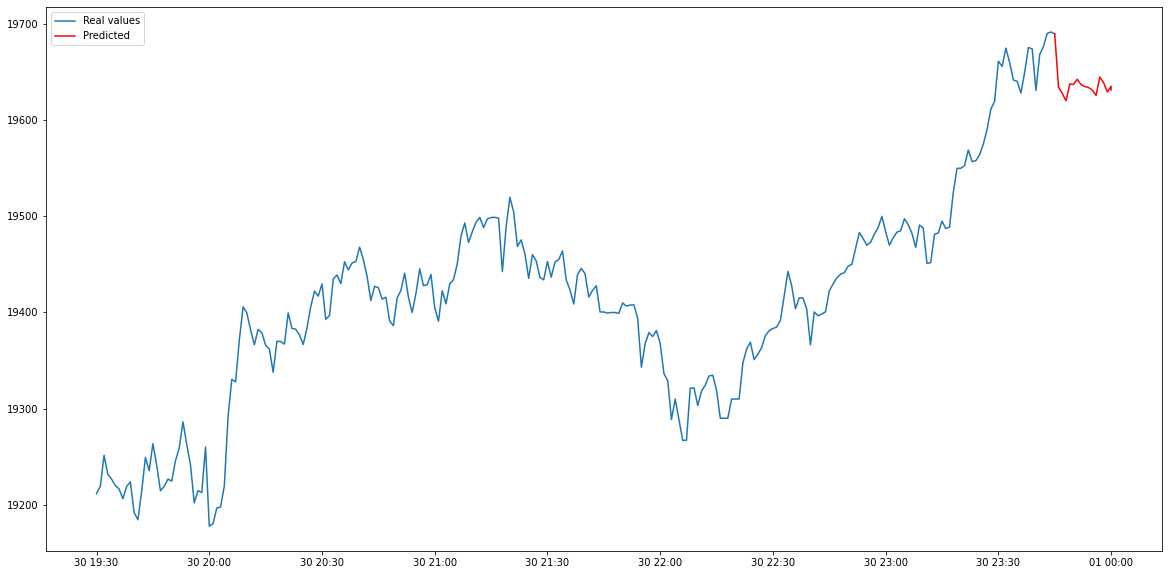

0      19211.54
1      19219.18
2      19251.39
3      19231.58
4      19226.64
         ...   
251    19668.32
252    19676.74
253    19690.33
254    19691.87
255    19689.76
Name: close, Length: 256, dtype: float64

In [37]:
o_df_2048 = test_df[:256]
o_df_2048


real_8192 = pd.DataFrame()
real_8192['timestamps'] = pd.to_datetime(np.array(o_df_2048['Timestamp']).reshape(-1), unit='ns')
real_8192['close'] = np.array(o_df_2048['Close'])

o_df_512_256 = test_df[-16:]
time_512_256 = pd.DataFrame()
time_512_256['timestamps'] = pd.to_datetime(np.array(o_df_512_256['Timestamp']).reshape(-1), unit='ns')


plt.figure(figsize=(20,10))
plt.plot(real_8192.timestamps, real_8192.close, label='Real values')


merge_chart = pd.DataFrame()

timestamps = np.concatenate((np.array(real_8192['timestamps']).reshape(-1)[-1], np.array(time_512_256['timestamps']).reshape(-1)[0]), axis=None) 
merge_chart['timestamps'] = pd.to_datetime(np.array(timestamps), unit='ns')
merge_chart['close'] = np.concatenate((np.array(real_8192['close']).reshape(-1)[-1], np.array(future_df['value']).reshape(-1)[0]), axis=None) 


# Merge two graphs
plt.plot(merge_chart.timestamps, merge_chart.close, color='red')




#plt.plot(real_chart_df.times, real_chart_df.value, label = 'Actual')
plt.plot(time_512_256.timestamps, future_df.value, color='red', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.savefig('LSTM-Future.png')
plt.show()

prediction_df['times'][0]
real_8192['close']

In [38]:
print("Mean squared error of prediction on test dataset = ", mean_squared_error(np.array(test_df[256:272]['Close']).tolist(), np.array(future_df['value']).tolist()))

Mean squared error of prediction on test dataset =  5960.719836713471
